A megoldott feladat egy 7 kimenettel rendelkező klasszifikáció, a felépített hálózat bemenetként kap egy emberi arcról egy képet, végeredményként megállapítja, hogy szerinte 7 érzelem (boldog, szomorú, dühös, riadt, meglepődött, undorott és semleges) közül melyik a leginkább igaz a képen látható arcról.

Az adathalmazok forrása: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset

In [14]:
import tensorflow as tf
from keras import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
imsize = 48

In [ ]:
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=15,
                               width_shift_range=0.15,
                               shear_range=0.15,
                               zoom_range=0.15,
                               horizontal_flip=True
                              )

train_data = train_gen.flow_from_directory("2-dataset\\train",
                                           target_size=(imsize, imsize),
                                           color_mode='grayscale',
                                           batch_size=32
                                          )

In [3]:
test_gen = ImageDataGenerator(rescale=1./255)

test_data = test_gen.flow_from_directory("2-dataset\\validation",
                                           target_size=(imsize, imsize),
                                           color_mode='grayscale',
                                           batch_size=32
                                         )

Found 7066 images belonging to 7 classes.


Az adatok már úgy lettek megadva, hogy ketté lett bontva egy tanító és egy validációs adathalmazra, az összes kép 48x48-as.

A csoportonként megtalálható képek száma a következő:

train:
angry: 3993, disgust: 436, fear: 4103, happy: 7164, sad: 4938, surprise: 3205, neutral: 4982

validation:
angry: 960, disgust: 111, fear: 1018, happy: 1825, sad: 1139, surprise: 797, neutral: 1216

A tanító adatbázis így nyilvánvalóan nagyon kiegyensúlyozatlan. Ezt a problémát először megpróbáltam úgy kezelni, hogy levágtam a többi csoportból, hogy többé-kevésbé egyenlő legyen a képek száma, de ez csak a pontosság csökkenésével járt, valószínűleg a túl kevés adat miatt. Így a megoldás az lett, hogy Data Augmentation segítségével megnöveltem az adathalmaz méretét, ami az overfitting túl korán jelentkezése ellen is segítséget nyújtott.

In [16]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience = 10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [17]:
model = Sequential()
model.add(Convolution2D(filters=64, kernel_size=(5, 5), input_shape=(imsize, imsize, 1), activation='elu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=64, kernel_size=(5, 5), activation='elu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Convolution2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Convolution2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Convolution2D(filters=512, kernel_size=(3, 3), activation='elu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='elu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(7, activation='softmax'))

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_9 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                      

A felépített hálózat egy CNN.

Minden konvolúciós réteget követ egy BatchNormalization réteg, amely normalizálja a bemeneti adatokat, ez minden MaxPooling réteg előtt kétszer ismétlődik meg, ezzel növelve a tanítás hatékonyságát. A konvolúciós réteg aktivációja elu, a kernel initializer pedig he normal, több kipróbált lehetőség közül ez a kombináció tűnt a leghatásosabbnak. Az utolsó kivételével minden konvolúciós rétegnél be lett állítva paddingre a same, hogy lassabban csökkenjen az inputok mérete, ezzel lehetőséget adva a mélyebb hálózat felépítésére. Minden MaxPooling után szerepel egy Dropout réteg az overfitting csökkentésének érdekében, a vége felé egyre nagyobb értékkel megadva.

A végén a 4x4-es input kilapítása után két teljesen összekötött réteg segítségével történik meg a klasszifikáció, a kimeneti réteg aktivációja softmax és az output paramétereinek a száma 7.

In [20]:
model.fit_generator(train_data,
                    epochs=100,
                    validation_data=test_data,
                    callbacks=[es, lr]
                   )

Epoch 1/100


C:\Users\novaa\AppData\Local\Temp/ipykernel_7276/1618630974.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_data,


901/901 [==============================] - 51s 56ms/step - loss: 2.0887 - accuracy: 0.2519 - val_loss: 1.6333 - val_accuracy: 0.3668 - lr: 0.0010
Epoch 2/100
901/901 [==============================] - 48s 53ms/step - loss: 1.6194 - accuracy: 0.3717 - val_loss: 1.4571 - val_accuracy: 0.4418 - lr: 0.0010
Epoch 3/100
901/901 [==============================] - 48s 53ms/step - loss: 1.4451 - accuracy: 0.4428 - val_loss: 1.3467 - val_accuracy: 0.4775 - lr: 0.0010
Epoch 4/100
901/901 [==============================] - 49s 54ms/step - loss: 1.3503 - accuracy: 0.4820 - val_loss: 1.2312 - val_accuracy: 0.5279 - lr: 0.0010
Epoch 5/100
901/901 [==============================] - 50s 55ms/step - loss: 1.2958 - accuracy: 0.5049 - val_loss: 1.2061 - val_accuracy: 0.5331 - lr: 0.0010
Epoch 6/100
901/901 [==============================] - 50s 55ms/step - loss: 1.2471 - accuracy: 0.5294 - val_loss: 1.1584 - val_accuracy: 0.5599 - lr: 0.0010
Epoch 7/100
901/901 [==============================] - 50s 55ms/

A tanítás futásához 100 epoch lett beállítva, de ahogy látható ez nem futott le teljesen, mivel lett Early Stopping beállítva az overfitting ellen 10 epoch türelmi idővel, amely a tanítás végén visszaállította az addigi legjobb súlyokat.

Továbbá be lett még állítva a ReduceLROnPlateau is, amely csökkentette a learning ratet, ha már 5 epoch óta nem történt javulás a validation loss monitorozása alapján.

In [28]:
model.save('2-dataset\\cnn8')

INFO:tensorflow:Assets written to: 2-dataset\cnn8\assets


In [4]:
model = tf.keras.models.load_model('2-dataset\\cnn8')

In [5]:
import numpy as np
import math

In [6]:
number_of_examples = len(test_data.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 32))

test_labels = []

for i in range(0,int(number_of_generator_calls)):
    test_labels.extend(np.array(test_data[i][1]))

In [7]:
test_labels_one = np.array([])
for i in range(len(test_labels)):
    for j in range(len(test_labels[i])):
        if(test_labels[i][j]==1):
            test_labels_one = np.append(test_labels_one, j)

In [8]:
pred_Y = np.argmax(model.predict(test_data), axis=1)

print(pred_Y.shape)
pred_Y = pred_Y.reshape(pred_Y.shape[0], 1)
print(pred_Y.shape)

real_Y = test_labels_one

print(real_Y.shape)
real_Y = real_Y.reshape(real_Y.shape[0], 1)
print(real_Y.shape)

(7066,)
(7066, 1)
(7066,)
(7066, 1)


In [9]:
np.concatenate((pred_Y, real_Y), axis=1)

array([[0., 2.],
       [3., 3.],
       [4., 4.],
       ...,
       [0., 2.],
       [6., 6.],
       [3., 3.]])

In [10]:
import sklearn.metrics
import math

In [11]:
cm = sklearn.metrics.confusion_matrix(real_Y, pred_Y)
labels = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]
print(sklearn.metrics.classification_report(real_Y, pred_Y, target_names=labels))

              precision    recall  f1-score   support

       angry       0.60      0.61      0.61       960
     disgust       0.78      0.63      0.70       111
        fear       0.62      0.44      0.51      1018
       happy       0.88      0.88      0.88      1825
         sad       0.56      0.77      0.65      1216
    surprise       0.59      0.51      0.55      1139
     neutral       0.78      0.79      0.79       797

    accuracy                           0.69      7066
   macro avg       0.69      0.66      0.67      7066
weighted avg       0.69      0.69      0.68      7066



In [12]:
import seaborn as sns

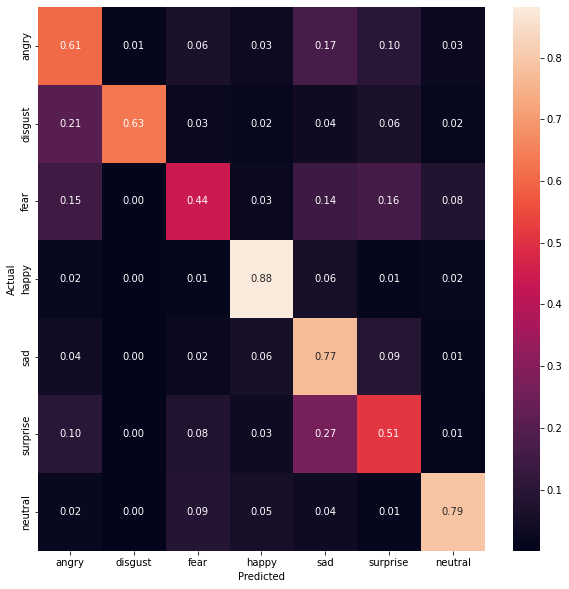

In [15]:
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [16]:
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

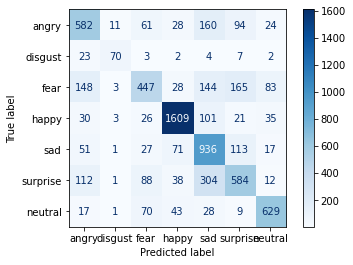

In [17]:
disp.plot(cmap=plt.cm.Blues)
plt.show()

A tanítás után történt a teljes validációs adathalmaz lefuttatása a betanított modellen, ezzel lehetővé téve az eredmények kiértékelését. Erre a feladatra többféle módszert is alkalmaztam.

A második és a harmadik egy-egy confusion matrix létrehozásához volt alkalmas, az első százalékos, a második pedig darabszám alapján adta meg az eltalált és az eltévesztett predikciók számát.
Az első módszer pedig az összes label f1-scoreja alapján adott a pontosságra egy számot, amely ebben az esetben 69% és egyben a legjobb elért eredményem lett.